<a href="https://colab.research.google.com/github/alexunderch/Master_materials/blob/main/gpaphs_and_nets/%D0%9C%D0%A2%D0%98%D0%98_%D0%B3%D1%80%D0%B0%D1%84%D1%8B_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание №3 по курсу «Графы и сети» (МТИИ, осень 2022)

Присылайте выполненное задание аналогично предыдущим домашним работам

In [ ]:
!pip install -qq pomegranate
!apt install libgraphviz-dev > /dev/null 
!pip install -qq pygraphviz 

     |████████████████████████████████| 4.3 MB 8.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


     |████████████████████████████████| 120 kB 8.7 MB/s 


### Задание 1
Постройте случайный граф на $n=200$ вершинах, согласно модели Эрдёша—Реньи с вероятностью появления ребра $p=\frac{1}{2}$. Напишите свой код генерации случайного графа, не пользуясь встроенным в `networkx` генератором [`gnp_random_graph`](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html) и подобными. Посчитайте кликовое число в среднем по 10-20 сгенерированных графах. Насколько кликовое число далёко от теоретического среднего в $2\log_{1/p}n$?

In [ ]:
import networkx as nx
from itertools import combinations
import numpy as np
import math

n = 200
p = .5
N = 15

def make_random_graph(n: int, p: float, _seed: int = None) -> nx.Graph:
    random.seed(_seed)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for u, v in combinations(G.nodes(), 2):
        if np.random.binomial(1, p) == 1:
            G.add_edge(u, v)
    return G

avg_nx = []
for _seed in range(N):
    avg_nx.append(nx.graph_clique_number(nx.gnp_random_graph(n, p)))
print("Sample clique number (`networkx`):", sum(avg_nx) / N)

avg = []
for _seed in range(N):
    G = make_random_graph(n, p, _seed)
    avg.append(nx.graph_clique_number(G))
print("Sample clique number:", sum(avg) / N)

print("Theoretical clique number:", 2 * math.log(n, 1/p))
print("Theoretical clique number (corrected):", 2 * math.log(n))

Sample clique number (`networkx`): 11.0
Sample clique number: 11.0
Theoretical clique number: 15.287712379549449
Theoretical clique number (corrected): 10.596634733096073


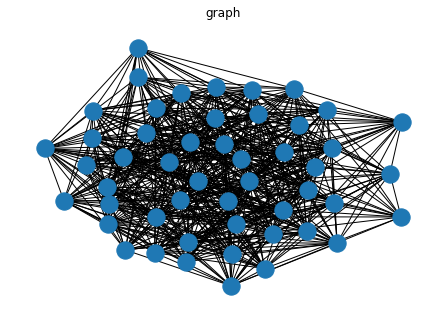

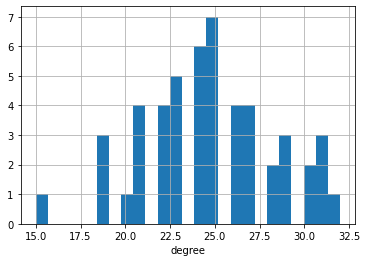

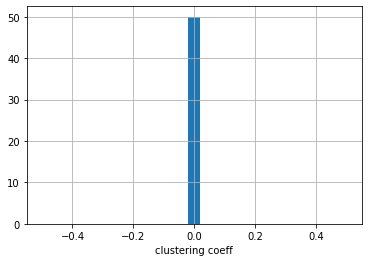

In [ ]:
G = make_random_graph(50, p = 1/2, _seed = 42)

nx.draw(G)
plt.title("graph")
plt.show()

plt.hist([ G.degree(node) for node in G.nodes()], bins = len(G)//2)
plt.grid()
plt.xlabel("degree")
plt.show()

plt.hist([int(nx.clustering(G, node)) for node in G.nodes()], bins = len(G)//2)
plt.grid()
plt.xlabel("clustering coeff")
plt.show()

В [книгe](https://www.mccme.ru/free-books/dubna/raigor-4.pdf) см. теорему 17, которая доказана для хроматического числа графа $\chi(G)$ для $p = \frac{1}{2}$. Как известно,
$\chi(G) \geq ω(G)$, а равенство достигается, например, на полных графах, но на произвольных оценка может и не достигаться.

### Задание 2
Смоделируйте случайный граф в модели предпочтительного присоединения или другой отличной от Эрдёша—Реньи (согласно Вашему представлению о естественном росте, скажем, социальной сети). Опишите свою модель и приведите пример характеристик графа, которые отличаются в Вашей модели от соответствующих характеристик модели Эрдёша—Реньи.

Возьмём модель роста социальной сети предпочтительного присоединения Барбаши-Альберта (`a Barabási–Albert preferential attachment model` [Википедия](https://en.wikipedia.org/wiki/Barabási–Albert_model)). Принцип предпочтительного присоединения заключается в том, что чем больше связей имеет узел, тем более предпочтительно для него создание новых связей. Узлы с наибольшей степенью имеют больше возможностей забирать себе связи, добавляемые в сеть. Интуитивно, принцип предпочтительно присоединения может быть понят, если мы думаем в терминах социальных сетей, которые объединяют людей.

Алгоритм работает следующим образом:
* на первом шаге инцииализируется стартовый граф на $n_0$ вершинах — я в качестве исходного взял `star_graph`($n_0$), это очень похоже на юзера с заданным количеством фолловеров;

* вершины добавляются к графу по $m$ штук, где вероятность добавления $i$-ой ноды есть
$$
p_i = \frac{deg(i)^α}{\sum_{j \in V(G)} deg(j)^α}, \\
\alpha > 0,
$$
пока количество вершин не станет равным заданному $n$.

$\alpha$ здесь — коэффициент нелинейности preferential attachement, при $α = 1$ имеющий классическое значения вероятности выбора вершины, пропорциональной её степени.

Сильно связанные узлы ("хабы") имеют тенденцию быстро накапливать еще больше ссылок, в то время как узлы с несколькими ссылками вряд ли будут выбраны в качестве места назначения для новой ссылки. Новые узлы имеют «предпочтение» присоединяться к уже сильно связанным узлам.

Основные особенности:
- Степенное распределение ($P(k) \sim k^{-3}$)
- Коэффициент кластеризации $C(k) = k^{-1}$
- кликовое число ниже, чем у модели ER

In [ ]:
import numpy as np
import networkx as nx
import random 
import matplotlib.pyplot as plt

def sample_nodes(G:nx.Graph, distribution: list, m: int):
    targets = set()

    while len(targets) < m:
        targets.add(np.random.choice(G.nodes(), p=distribution))
    return targets

def barabasi_albert_graph(n: int, m: int, alpha: float, initial_graph: nx.Graph) -> nx.Graph:
    assert m >= 1 and m <= n
    assert alpha > 0 

    G = initial_graph.copy()

    source = len(G)
    while source < n:
        degrees = np.array([d ** alpha for _, d in G.degree()])
        degrees /= degrees.sum()
        targets = sample_nodes(G, degrees, m)

        G.add_edges_from(zip([source] * m, targets))

        source += 1
    return G

def compute_statistics(G: nx.Graph) -> dict:
    return dict(
        avg_clustering_coeff = nx.average_clustering(G),
        clique_number = nx.graph_clique_number(G),
        degree_distibution = np.mean([x[1] for x in G.degree()])
    )

def set_experiment(initial_followers: int, target_followers: int, added_followers: int, pref_att_coeff: float, seed: int):
    random.seed(seed)
    np.random.seed(seed)

    initial_graph = nx.star_graph(initial_followers)
    G = barabasi_albert_graph(target_followers, added_followers, pref_att_coeff, initial_graph)
    return G, compute_statistics(G)


In [ ]:
n0 = 15
n = 50
m = 10
alpha = 1.0
total_stats = dict(
                    avg_clustering_coeff = [],
                    clique_number = [],
                    degree_distibution = []
                  )

for seed in range(20):
    G, stats =  set_experiment(n0, n + seed, m, alpha, seed)
    for k in total_stats.keys():
        total_stats[k].append(stats[k])

for k in total_stats.keys():
    print(f"mean {k}: {np.mean(total_stats[k])}")


                               

mean avg_clustering_coeff: 0.27103668940552306
mean clique_number: 5.1
mean degree_distibution: 15.079487277167479


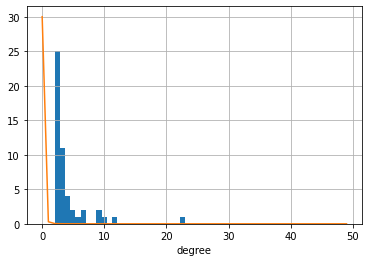

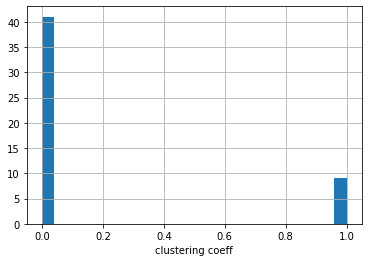

In [ ]:
seed = 42
n0 = 2
n = 50
m = 2
alpha = 1.0
G, stats =  set_experiment(n0, n, m, alpha, seed)
plt.hist([ G.degree(node) for node in G.nodes()], bins = len(G)//2)
plt.grid()
plt.plot(list(G.nodes()), [3./ (node ** 3 + 1e-1)for node in G.nodes()])
plt.xlabel("degree")
plt.show()

plt.hist([int(nx.clustering(G, node)) for node in G.nodes()], bins = len(G)//2)
plt.grid()
plt.xlabel("clustering coeff")
plt.show()

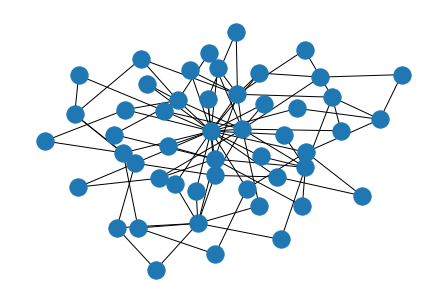

In [ ]:
nx.draw_kamada_kawai(G) 

Данная модель лучше модели Эрдёша—Реньи, так как может учитывать динамику роста социальных сетей — модель Бернулли не учитывает степенной закон распределения степеней вершин и "узость" графа социальной сети, а такой, очень грубый вариант такой модели позволяет как-то учесть подобные особоенности.

### Задание 3
Смоделируйте с помощью скрытой марковской модели следующую ситуацию. Гражданин Рассеянный в зависимости (почти) от погоды надевает либо футболку, либо плащ, либо тулуп. Когда жарко, он равновероятно надевает каждый из трёх видов одежды. Когда холодно, он не надевает плащ, а равновероятно надевает футболку либо тулуп. Когда температура средняя, он надевает исключительно тулуп либо плащ. Температура никогда не меняется резко (жаркая погода сменяется на холодную, и наоборот, — только через среднее состояние); при этом каждое состояние погоды равновероятно может остаться без изменений либо смениться на любое другое допустимое. На протяжении недели Рассеянный постил свои фото в Instagram в следующей одежде:
- пн: тулуп,
- вт: тулуп,
- ср: плащ,
- чт: футболка,
- пт: плащ,
- сб: плащ,
- вс: футболка.

Какая наиболее вероятная погода стояла на улице Бассейной в каждый из этих дней?

In [ ]:
import pomegranate as pg

weather = ["cold", "warm", "hot"]
clothes = ["coat", "tshirt", "cloak"]
dow = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
probs = [[0.5, 0.5, 0.0], [0.5, 0., 0.5], [1./3, 1./3, 1./3]]

dist = {w: pg.DiscreteDistribution({c: p for c, p in zip(clothes, probs[i])})\
        for i, w in enumerate(weather)}

states = [pg.State(state_dist, name = state_name)\
          for state_name, state_dist in dist.items()]
hmm = pg.HiddenMarkovModel(name = "bruh")
hmm.start.name = "start"
hmm.end.name = "end"
hmm.add_states(states)

hmm.add_transitions(hmm.start, states, [1./3, 1./3, 1./3])
hmm.add_transitions(states, hmm.end, [1./3, 1./3, 1./3])

hmm.add_transitions(states[0], [states[0], states[1], states[2]], [0.5, 0.5, 0.0])
hmm.add_transitions(states[1], [states[0], states[1], states[2]], [1./3, 1./3, 1./3])
hmm.add_transitions(states[2], [states[0], states[1], states[2]], [0.0, 0.5, 0.5])
hmm.bake()


logp, path = hmm.viterbi(["coat", "coat", "cloak", "tshirt", "cloak", "cloak", "tshirt"])
print(f"likelihood: {logp}")
print(
    " -> ".join([
        step[1].name \
        for ind, step in enumerate(path)
        ])
)

likelihood: -14.438307738602468
start -> cold -> cold -> warm -> cold -> warm -> warm -> cold -> end


### Задание 4
С использованием pomegranate или другой (согласованной предварительно) библиотеки смоделируйте следующую ситуацию. 

Виктор работает в фирме Macrohard вместе со своими коллегами Кейт и Джоном. В городе, где находится офис Macrohard, с вероятностью 0.1 может произойти землетрясение. В этом случае по радио гарантированно объявляют об угрозе землетрясения, а в зданиях с вероятностью 0.4 от сейсмического толчка срабатывает сигнализация. Кроме того, с вероятностью 0.02 в здании может произойти ограбление и в этом случае сигнализация сработает наверняка. Джон и Виктор не слушают радио во время обеденного перерыва, а Кейт включает радио с вероятностью 0.5. Если происходит что-то необычное, Кейт всегда звонит Виктору, а Джон звонит Виктору с вероятностью 0.3. Джон и Кейт обычно обедают в офисе, а Виктор перекусывает в парке. 

Случилось следующее:  во время обеда Кейт позвонила Виктору и сказала, что, вероятно, в городе землетрясение. К сожалению, ровно в этот момент сел аккумулятор в её смартфоне, и Виктор так и не понял, Кейт позвонила ему потому, что услышала о землетрясении по радио, или потому, что Кейт осталась обедать в офисе и услышала сигнализацию. Джон Виктору не позвонил. Какова (апостериорная) вероятность того, что в городе землетрясение?

In [ ]:
import pomegranate as pg
bayesian_net = pg.BayesianNetwork("'Why did Kate call Victor?' Problem")

Eathquake = pg.DiscreteDistribution({"1": 0.1, "0": 0.9})
Robbery = pg.DiscreteDistribution({"1": 0.02, "0": 0.98})


Alarm =  pg.ConditionalProbabilityTable([
            ["1", "0", "0", 0.0], #p(A|nothing)
            ["1", "0", "1", 1.0], #p(A|E)
            ["1", "1", "0", 0.0], #p(A|R)
            ["1", "1", "1", 1.0], #p(A|R, E)
            ###################
            ["0", "0", "0", 1.0], #p(not A|nothing)
            ["0", "0", "1", 0.0], #p(not A|E)
            ["0", "1", "0", 0.6], #p(not A|R)
            ["0", "1", "1", 0.4]], [Robbery, Eathquake])

KateRadio =  pg.ConditionalProbabilityTable([
            ["1", "1", 0.5],
            ["1", "0", 0.5],
            ["0", "1", 0.0],
            ["0", "0", 1.0]], [Eathquake])

KateVictor = pg.ConditionalProbabilityTable([ #(i oj j) == k
            ["1", "0", "0", 0.0], 
            ["1", "0", "1", 1.0],
            ["1", "1", "0", 0.0],
            ["1", "1", "1", 1.0],
            ###################
            ["0", "0", "0", 1.0],
            ["0", "0", "1", 0.0],
            ["0", "1", "0", 0.0],
            ["0", "1", "1", 1.0]], [Alarm, KateRadio])

JohnVictor =  pg.ConditionalProbabilityTable([
            ["1", "1", 0.3],
            ["1", "0", 0.7],
            ["0", "1", 0.0],
            ["0", "0", 1.0]], [Alarm])
dists = {
    Eathquake: "Eathquake",
    Robbery: "Robbery",
    Alarm: "Alarm",
    KateRadio: "KateRadio",
    KateVictor: "KateVictor",
    JohnVictor: "JohnVictor"
}

state_maker = lambda dist: {state_name: pg.State(state_dist, name = state_name)\
                            for state_dist, state_name in dist.items()}

states = state_maker(dists)

bayesian_net.add_states(*list(states.values()))
bayesian_net.add_edge(states["Eathquake"], states["Alarm"])
bayesian_net.add_edge(states["Robbery"], states["Alarm"])

bayesian_net.add_edge(states["Eathquake"], states["KateRadio"])
bayesian_net.add_edge(states["KateRadio"], states["KateVictor"])


bayesian_net.add_edge(states["Alarm"], states["KateVictor"])
bayesian_net.add_edge(states["Alarm"], states["JohnVictor"])


bayesian_net.bake()

States: Eathquake Robbery Alarm KateRadio KateVictor JohnVictor
The net: 



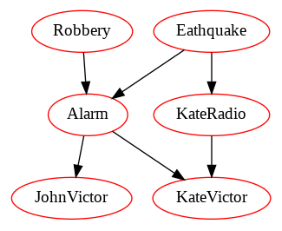

In [ ]:
print("States:", *[s.name for s in bayesian_net.states])
print("The net: \n")
bayesian_net.plot()

In [ ]:
x = [None, None, None, None, "1", "0"]
print("Decisions")
list(zip([x.name for x in bayesian_net.states],
    list(bayesian_net.predict([x])[0])))

Decisions


[('Eathquake', '1'),
 ('Robbery', '0'),
 ('Alarm', '1'),
 ('KateRadio', '1'),
 ('KateVictor', '1'),
 ('JohnVictor', '0')]

In [ ]:
print("p(E | Kate called Victor) = ", bayesian_net.predict_proba([x])[0][0].parameters[0]["1"])

p(E | Kate called Victor) =  0.5978306773109098
